<a href="https://colab.research.google.com/github/Samir-atra/Machine-Learning/blob/main/GAN/LeafGAN/CitrusGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

leaf datasets are from tensorflow datasets and maybe swedish leaves

In [19]:
# Imports

import numpy as np
import pathlib
import matplotlib.pyplot as plt
import IPython
import sys
import time
import cv2
import os
import tensorflow as tf
import datetime
from IPython import display

%load_ext autoreload
%autoreload 2

from google.colab import drive             
drive.mount('/content/drive')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Dataset loading

data_path = pathlib.Path('/content/drive/MyDrive/LeafDataset/Leaves/Leafdataset/Training/Leaf/')

# data_path_test = pathlib.Path('/content/drive/MyDrive/CarsDataset')


dataset_path, dataset_path_val = tf.keras.utils.image_dataset_from_directory(        # Training nd validation datasets
    data_path,
    labels= 'inferred',
    label_mode= None,
    validation_split=0.2,
    subset='both',
    seed= 1,
    batch_size=8,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True)


# BUFFER_SIZE = 60000
BATCH_SIZE = 8
EPOCHS = 500
noise_dim = 128
num_examples_to_generate = 1

Found 436 files belonging to 1 classes.


In [21]:
AUTOTUNE=tf.data.AUTOTUNE
dataset_path = dataset_path.cache().prefetch(buffer_size=AUTOTUNE)
# dataset_path_val = dataset_path_val.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
# The generator

def make_generator_model():
    model = tf.keras.Sequential([
    # tf.keras.layers.Reshape((5, 28, 28, 1)),
    # tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1), 
    # tf.keras.layers.Normalization(axis=None, mean=0, variance=1),
    tf.keras.layers.Dense(32*32*512, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Reshape((32, 32, 512)),

    tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(1, 1), padding='same', use_bias=False, kernel_initializer='glorot_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(1, 1), padding='same', use_bias=False),# kernel_initializer='glorot_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(1, 1), padding='same', use_bias=False, kernel_initializer='glorot_normal'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', use_bias=False, kernel_initializer='glorot_normal'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.LeakyReLU(),

    # tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer='glorot_normal'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(3, (2, 2), strides=(2, 2), padding='same', use_bias=False, activation='softmax', kernel_initializer='glorot_normal'),
    ])

    return model

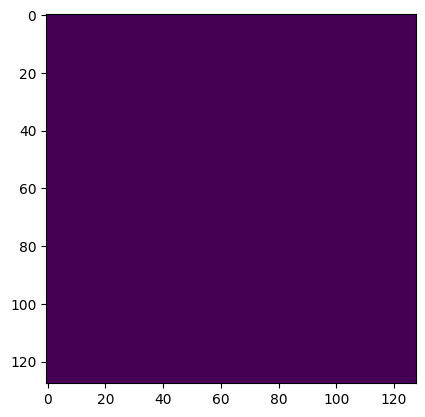

In [23]:
# Image generation

generator = make_generator_model()    
noise = tf.random.normal([1, 128])
generated_image = generator(noise, training=True)
plt.imshow(generated_image[0, :, :, 0])

In [24]:
# The discriminator

def make_discriminator_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (2, 2), strides=(2, 2), padding='same',input_shape=[128, 128, 3], kernel_initializer='glorot_normal', activation = "leaky_relu"),
    # tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    # tf.keras.layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', kernel_initializer='glorot_normal'),
    # tf.keras.layers.LeakyReLU(),
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer='glorot_normal', activation = "leaky_relu"),
    # tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (2, 2), strides=(2, 2), padding='same', kernel_initializer='glorot_normal', activation = "leaky_relu"),
    # tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (2, 2), strides=(2, 2), padding='same', kernel_initializer='glorot_normal', activation = "leaky_relu"),
    # tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    # tf.keras.layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', kernel_initializer='glorot_normal'),
    # tf.keras.layers.LeakyReLU(),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(1, activation=None),
    ])

    model.summary()

    # model.compile(
    # optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00008),        # compiling with low learning rate
    # loss=tf.losses.BinaryCrossentropy(),
    # metrics=['accuracy'])

    return model

In [25]:
# Decision making

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        416       
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 batch_normalization_14 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_15 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                     

In [26]:
# loos function to be used

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
# Discriminator loss

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [28]:
# count the generator loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
# Optimizers

generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

In [30]:
# checkpoints

checkpoint_dir = '/content/drive/MyDrive/GANCheckpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir , max_to_keep=1)

In [31]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [32]:
# go through one training step

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [33]:
# training function for the GAN

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

  
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    
    if (epoch + 1) % 10 == 0:
      # manager.save()
      print("tenth is here")
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # if (epoch + 1) % 11 == 0:
    #   service = discovery.build('drive', 'v2')  # stackoverflow stuff
    #   service.files().emptyTrash().execute()
    # Generate after the final epoch
    # display.clear_output(wait=True)
    # generate_and_save_images(generator,
    #                          epochs,
    #                          seed)

In [34]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=True)

  # fig = plt.figure(figsize=(1, 1))
  for i in range(predictions.shape[0]):
      plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')
  plt.savefig('image_at_epoch_{}.png'.format(epoch))
  plt.show()

In [35]:
# plt.imshow(generated_image[0])
# plt.show()

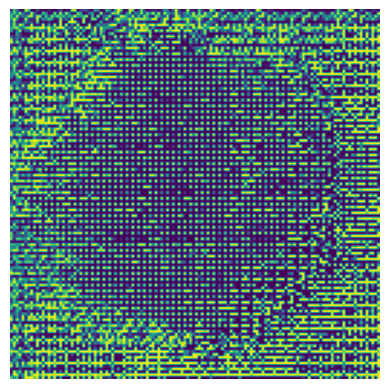

tenth is here
Time for epoch 500 is 2.319474935531616 sec


In [36]:
# for restoring
# if manager.latest_checkpoint:
#   checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Train the model
train(dataset_path, EPOCHS)

A record of changes after getting Leafish shape:

- strides on conv2dT2 from (1,1) to (2,2) DOES NOT WORK

- the dropout rates of discriminator layers now all 0.2, at 0.1 the leaf disappear

- got the generator input shape down from (32,32,512) to (32,32,256) which showed a leafish shape on the first run then vanished in the second. and keep appearing and vanishing with more epochs (big randomness in the results)

- now introducing a "resize" layer in the start of discriminator to give it (64,64,3) gives good few epochs and then vanish

- divide all the discriminator hidden unites numbers by two hope for a longer life for the gradient, and again with the vanishing so will start working on the generator because probably the dis is working by the proof of the first few epochs.

- first on the gen got first conv2dT from 512 to 256 A MESS

- to get it close from the dis model got 128-128-64-32-3 on gen. 

- mul all layer by 2 got some noise in the beginning 

- just wanted to say that I think something's size is really wrong

- now has same conv layer in gen as leafish and training for batch norm is off and first generated image.